### Imports

In [47]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pingouin as pg
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects
from stats_utils import bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in sessions

In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()

### Examine firing rates of interneurons in each session

In [59]:
# Calculate mean firing rates
neuron_type = "stable" # "stable" # 'all' or 'stable'
fr_df = []
for ids, sess in enumerate(sessions):
    assert neuron_type in ("all", "stable")
    neurons_use = sess.neurons if neuron_type == "all" else sess.neurons_stable
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    fr_df_maze = neurons_use.time_slice(*maze).to_dataframe()
    fr_df_maze["session_type"] = "MAZE"
    
    fr_df_remaze = neurons_use.time_slice(*remaze).to_dataframe()
    fr_df_remaze["session_type"] = "reMAZE"

    delta_fr = fr_df_maze["mean_frate"] - fr_df_remaze["mean_frate"]
    fr_df_maze["delta_frate_maze_remaze"] = delta_fr
    fr_df_remaze["delta_frate_maze_remaze"] = np.nan
    
    fr_df_temp = pd.concat((fr_df_maze, fr_df_remaze), axis=0)
    fr_df_temp['neuron_id'] = fr_df_temp.index
    
    fr_df_temp["grp"] = sess.tag
    fr_df_temp["session"] = ids

    fr_df.append(fr_df_temp)
    
fr_df = pd.concat(fr_df, axis=0, ignore_index=True)
fr_df["nid_unique"] = fr_df.apply(lambda row: f"{row.session}_{row.neuron_id}", axis=1)
fr_df.to_csv(group_data_dir / "remaze_fr.csv")
fr_df

Number of neurons: 123
Number of neurons: 123
Number of neurons: 249
Number of neurons: 249
Number of neurons: 99
Number of neurons: 99
Number of neurons: 95
Number of neurons: 95
Number of neurons: 95
Number of neurons: 95
Number of neurons: 66
Number of neurons: 66
Number of neurons: 185
Number of neurons: 185
Number of neurons: 62
Number of neurons: 62
Number of neurons: 49
Number of neurons: 49


,neuron_type,neuron_id,nspikes,mean_frate,session_type,delta_frate_maze_remaze,grp,session,nid_unique
0,pyr,0,777,0.211659,MAZE,0.125499,NSD,0,0_0
1,pyr,1,1994,0.543176,MAZE,-0.005908,NSD,0,0_1
2,mua,2,11173,3.043585,MAZE,0.579460,NSD,0,0_2
3,pyr,3,180,0.049033,MAZE,-0.058142,NSD,0,0_3
4,pyr,4,740,0.201580,MAZE,0.084198,NSD,0,0_4
...,...,...,...,...,...,...,...,...,...
2041,pyr,44,6841,1.760422,reMAZE,NaN,SD,8,8_44
2042,pyr,45,369,0.094956,reMAZE,NaN,SD,8,8_45
2043,pyr,46,6436,1.656202,reMAZE,NaN,SD,8,8_46
2044,pyr,47,98,0.025219,reMAZE,NaN,SD,8,8_47


### Bootstrap resample mean firing rates

#### Mean rates first

In [31]:
fr_df_rs = fr_df.pivot_table(index=["grp", "session", "neuron_id", "neuron_type"], 
                             columns="session_type", 
                             values="mean_frate").reset_index().drop(columns="neuron_id")

func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs_all = []
for ntype in ["pyr", "inter", "mua"]:
    print(ntype)
    df_use = fr_df_rs[fr_df_rs.neuron_type == ntype].drop(columns="neuron_type")
    df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
    df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name="mean_frate", ignore_index=False)
    df_bs["neuron_type"] = ntype
    df_bs_all.append(df_bs)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=False)
df_bs.to_csv(group_data_dir / "remaze_fr_bootstrap.csv")
df_bs

pyr
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:31<00:00, 315.75it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 286.36it/s]


inter
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 334.41it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 292.84it/s]


mua
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:30<00:00, 329.57it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 286.49it/s]


,grp,session,mean_frate,neuron_type
0,NSD,MAZE,1.091980,pyr
1,NSD,MAZE,1.304717,pyr
2,NSD,MAZE,1.095490,pyr
3,NSD,MAZE,1.062064,pyr
4,NSD,MAZE,0.940262,pyr
...,...,...,...,...
19995,SD,reMAZE,8.871773,mua
19996,SD,reMAZE,5.697908,mua
19997,SD,reMAZE,8.239004,mua
19998,SD,reMAZE,7.535709,mua


#### Delta rates second

In [61]:
fr_df_rs = fr_df.pivot_table(index=["grp", "session", "neuron_id", "neuron_type"], 
                             columns="session_type", 
                             values="delta_frate_maze_remaze").reset_index().drop(columns="neuron_id")

func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs_all = []
for ntype in ["pyr", "inter", "mua"]:
    print(ntype)
    df_use = fr_df_rs[fr_df_rs.neuron_type == ntype].drop(columns="neuron_type")
    df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
    df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE"], var_name="session", value_name="delta_frate", ignore_index=False)
    df_bs["neuron_type"] = ntype
    df_bs_all.append(df_bs)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=False)
df_bs.to_csv(group_data_dir / "remaze_fr_delta_bootstrap.csv")
df_bs

pyr
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:30<00:00, 329.41it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:33<00:00, 300.70it/s]


inter
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 340.44it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:33<00:00, 301.53it/s]


mua
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 338.96it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:33<00:00, 300.45it/s]


,grp,session,delta_frate,neuron_type
0,NSD,MAZE,0.263739,pyr
1,NSD,MAZE,0.016412,pyr
2,NSD,MAZE,0.204720,pyr
3,NSD,MAZE,0.043214,pyr
4,NSD,MAZE,0.289686,pyr
...,...,...,...,...
19995,SD,MAZE,0.773430,mua
19996,SD,MAZE,0.007888,mua
19997,SD,MAZE,-1.007258,mua
19998,SD,MAZE,-0.035485,mua


<Axes: xlabel='grp', ylabel='mean_frate'>

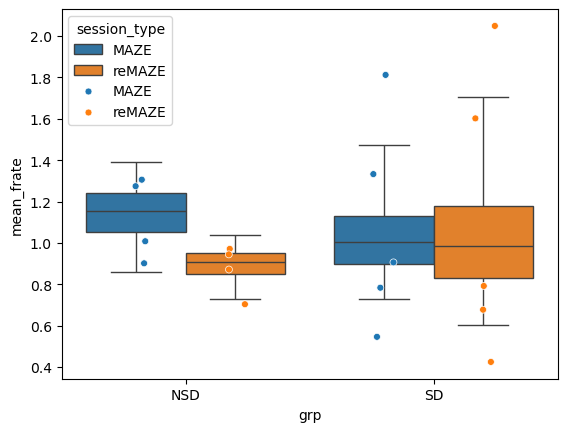

In [57]:
_, ax = plt.subplots()
ntype = "pyr"
df2 = df_bs[df_bs.neuron_type == ntype]
df2_mean = fr_df[fr_df.neuron_type == ntype].groupby(["grp", "session_type", "session"]).mean(numeric_only=True)
sns.boxplot(data=df2, x="grp", y="mean_frate", hue="session", whis=(2.5, 97.5), showfliers=False, ax=ax)
sns.stripplot(data=df2_mean, x="grp", y="mean_frate", hue="session_type", dodge=True, edgecolor="w", linewidth=0.5, ax=ax)

In [55]:
grp = "NSD"
df_grp = df2[df2.grp == grp]
get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"].mean_frate, df_grp[df_grp.session == "reMAZE"].mean_frate)

(0.24590336141255406, 0.008199999999999985)

In [ ]:
fr_df_rs.neuron_type.unique()

In [ ]:
fr_df_rs = fr_df.pivot_table(index=["grp", "session", "neuron_id", "neuron_type"], 
                             columns="session_type", 
                             values="mean_frate").reset_index().drop(columns="neuron_id")

func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_use = fr_df_rs[fr_df_rs.neuron_type == "inter"].drop(columns="neuron_type")
df_bs = bootstrap_resample(df_use, level="both", n_iter=1000, apply=func)
df_bs

In [ ]:
pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name="mean_frate")

In [ ]:
_, ax = plt.subplots()
df2 = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name="mean_frate")
sns.boxplot(data=df2, x="grp", y="mean_frate", hue="session", ax=ax)

In [ ]:
# Use to look at t-tests for each session - not that meaningful due to generally low n for most sessions with interneurons
fr_use = fr_df[fr_df.neuron_type == "inter"]
for sid in fr_use.session.unique():
    print(pg.ttest(fr_use[(fr_use.session == sid) & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.session == sid) & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

In [ ]:
fr_use = fr_df[fr_df.neuron_type == "inter"]

# Significant drop of inhibition for SD group but not NSD group with paired t-test (for stable neurons only, doesn't hold if we include all)

print(pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

# sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
#                 fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"])

# Distribution of interneuron firing rates is different between groups as well (stable neurons only, doesn't hold if we include all)
stats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"],
                fr_use[(fr_use.grp == "NSD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"])

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(4, 6))
for ax, ntype, nname in zip(axs, ["pyr", "inter"], ["Pyr. Cells", "Interneurons"]):
    fr_use = fr_df[fr_df.neuron_type == ntype]
    print(f"{ntype} below")
    print(pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

    for idg, (gname, a) in enumerate(zip(["NSD", "SD"], ax)):
        pal_use = sns.color_palette()[idg:]
        sns.lineplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate",
                     hue="grp", units="nid_unique", estimator=None, legend=False, palette=pal_use, ax=a)
        sns.stripplot(data=fr_df[(fr_df.neuron_type == ntype) & (fr_df.grp == gname)], x="session_type", y="mean_frate", 
                      hue="grp", dodge=True, jitter=True, legend=False, palette=pal_use, ax=a)
        a.set_title(f"{gname}: {nname}")
        a.set_ylabel("Mean FR (Hz)")
        a.set_xlabel("")

sns.despine(fig=fig)

fig.savefig(plot_dir / "fr_stripplot_maze_v_remaze.pdf")

In [ ]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette(as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])


In [ ]:
for ntype, nname in zip(["pyr", "inter"], ["Pyramidal Cells", "Interneurons"]):
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    fig.suptitle(nname)

    ax = axs[0]
    sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", dodge=True, ax=ax[0])
    # sns.lineplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", units="unique_nid", estimator=None, ax=ax[0])
    sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", split=True, ax=ax[1])
    [a.set_ylabel("Mean FR (Hz)") for a in ax];
    
    ax2 = axs[1]
    # sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", split=True, ax=ax2[0])
    sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], y="delta_frate_maze_remaze", hue="grp", dodge=True, ax=ax2[0])
    ax2[0].set_ylabel(r"$FR_{MAZE} - FR_{reMAZE}$")
    ax2[0].set_xlabel("")
    sns.ecdfplot(data=fr_df[fr_df.neuron_type == ntype], x="delta_frate_maze_remaze", hue="grp", ax=ax2[1])
    ax2[1].set_xlabel(r"$FR_{MAZE} - FR_{reMAZE}$")

    sns.despine(fig=fig)
    fig.savefig(plot_dir / f"FR_{ntype}delta_comprenhensive.pdf")